In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

Google Drive 에서 데이터 파일 마운트 하려면 다음과 같이 하면되지만, 프로그래밍 편의를 위해 wget 으로 직접 다운로드 함

from google.colab import drive   

drive.mount('/content/gdrive/')  

import shutil

shutil.copy('/content/gdrive/My Drive/Colab Notebooks/dataset/GTSRB_Final_Training_Images.zip', '/content/')

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

import shutil

shutil.copy('/content/gdrive/My Drive/Colab Notebooks/GTSRB_Final_Training_Images.zip', '/content/')


# 파일 다운로드

#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

Mounted at /content/gdrive/


'/content/GTSRB_Final_Training_Images.zip'

In [4]:
import os
import shutil

if os.path.exists('/content/GTSRB/'):    # 작업 디렉토리는 GTSRB
    
    shutil.rmtree('/content/GTSRB/')
    print('/content/GTSRB/  is removed !!!')

In [5]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/GTSRB_Final_Training_Images.zip', 'r') as target_file:

    target_file.extractall('/content/GTSRB_Final_Training_Images/') 

압축을 풀어보면, 데이터 디렉토리 구조는 다음과 같음

GTSRB_Final_Training_Images
 |- GTSRB
     |- Final_Training
         |- Images
             |- 00000
             |- 00001
             |- 00002
             |- .....
             |- 00042

이러한 데릭토리 구조에서 딥러닝 학습을 위한 일반적인 디렉토리 구조로 변경할 계획임. 즉 train : test = 8: 2 비율로 나누어서 각각의 디렉토리에 저장하는 데이터 전처리 코드 필요함

GTSRB
 |- train
     |- 00000
     |- 00001
     |- .....
     |- 00042
 |- test
     |- 00000
     |- 00001
     |- .....
     |- 00042

In [6]:
# 데이터 전체 개수 확인

import os
import glob

# 데이터 정답 (label) 개수 및 종류 확인

label_name_list = os.listdir('/content/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/')

print('total label nums = ', len(label_name_list))
print('=================================================')
print(label_name_list)

total label nums =  43
['00022', '00007', '00033', '00031', '00041', '00016', '00020', '00038', '00030', '00032', '00021', '00024', '00027', '00008', '00015', '00001', '00011', '00035', '00034', '00004', '00029', '00013', '00042', '00018', '00014', '00037', '00019', '00040', '00000', '00002', '00026', '00025', '00010', '00006', '00003', '00023', '00017', '00009', '00039', '00036', '00005', '00012', '00028']


원본 image를 정답 디렉토리 별로 읽어서 x_train numpy 생성 
train label 읽어서 y_train numpy 생성

In [7]:
import os
import cv2
import glob
import numpy as np
from datetime import datetime

image_list = []
label_list = []

image_base_dir = '/content/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/'

image_label_list = os.listdir(image_base_dir)    # 정답이름

print('label nums => ', len(image_label_list))

start_time = datetime.now()

for label_name in image_label_list:

    # 이미지 파일 읽어오기

    file_path = image_base_dir + label_name

    img_file_list = glob.glob(file_path+'/*.ppm')

    # 각각의 정답 디렉토리에 있는 이미지 파일, 즉 .ppm 파일 읽어서 리스트에 저장
    
    for img_file in img_file_list:

        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) 

        src_img = cv2.resize(src_img, dsize=(32,32))

        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

        image_list.append(src_img)
        label_list.append(float(label_name))  # 정답은 문자열을 실수로 변환


# numpy 변환

x_train = np.array(image_list).astype('float32')
y_train = np.array(label_list).astype('float32')

print('x_train.shape = ', x_train.shape, ', y_train.shape = ', y_train.shape)

end_time = datetime.now()

print('train data generation time => ', end_time-start_time)


label nums =>  43
x_train.shape =  (39209, 32, 32, 3) , y_train.shape =  (39209,)
train data generation time =>  0:00:01.832783


test data 생성. train : test = 8 : 2 

단, 데이터 다양성을 위해서 train data 를 먼저 random shuffle 한후에 test data 생성함. 이때 주의할것은 label data 도 동일한 인덱스로 shuffle 되어야 한다는 것이다 

In [8]:
import numpy as np

s = np.arange(len(x_train))

print('x_train len = ', s)

# index random shuffle

np.random.shuffle(s)

# x_train, y_train 재 생성

x_train = x_train[s]
y_train = y_train[s]

x_train len =  [    0     1     2 ... 39206 39207 39208]


x_train : x_test = 8 : 2

In [9]:
ratio = 0.2

split_num = int(ratio*len(x_train))

print('split num => ', split_num)

x_test = x_train[0:split_num]
y_test = y_train[0:split_num]

x_train = x_train[split_num:]
y_train = y_train[split_num:]

split num =>  7841


x_train, x_test, y_train, y_test shape 확인

In [10]:
print('x_train.shape = ', x_train.shape, ', y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape, ', y_test.shape = ', y_test.shape)

x_train.shape =  (31368, 32, 32, 3) , y_train.shape =  (31368,)
x_test.shape =  (7841, 32, 32, 3) , y_test.shape =  (7841,)


In [11]:
print(y_train[:3])
print(y_test[:3])

[32. 13.  4.]
[25. 25.  9.]


데이터 정규화

In [12]:
# 정규화 

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# one-hot encoding 하기 위해서는, 정답에 대해서 다음과 같이 실행함

#y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

이미지 출력

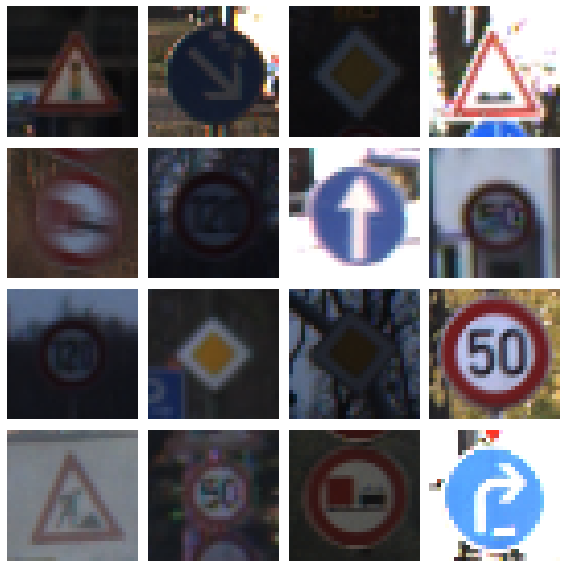

In [13]:
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(x_train), 16)    # 16개 랜덤 train 데이터 추출 

plt.figure(figsize=(8,8))

for pos in range(len(random_index)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')
    train_img_index = random_index[pos]
    plt.imshow(x_train[train_img_index])

plt.tight_layout()
plt.show()

Sequential 모델 구축

In [14]:
n_classes = len(os.listdir('/content/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/'))  # 정답 개수

cnn = Sequential()

cnn.add(Conv2D(input_shape=(32,32,3), kernel_size=(3,3), filters=32, activation='relu'))
cnn.add(Conv2D(kernel_size=(3,3), filters=64, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(n_classes, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 512)               6423040   
                                                        

In [15]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_file_name = './GTSRB_Native_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       # file명을 지정
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출
                             verbose=1,            # 로그를 출력
                             save_best_only=True,  # 가장 best 값만 저장
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss', # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5회 Epoch동안 개선되지 않는다면 종료
                             )

start_time = datetime.now()

hist = cnn.fit(x_train, y_train, 
               batch_size=32, epochs=30, 
               validation_data=(x_test, y_test),
               callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

Epoch 1/30
981/981 [==============================] - ETA: 0s - loss: 0.8618 - accuracy: 0.7632
Epoch 1: val_loss improved from inf to 0.15255, saving model to ./GTSRB_Native_Colab.h5
981/981 [==============================] - 15s 7ms/step - loss: 0.8618 - accuracy: 0.7632 - val_loss: 0.1526 - val_accuracy: 0.9626
Epoch 2/30
980/981 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.9476
Epoch 2: val_loss improved from 0.15255 to 0.07806, saving model to ./GTSRB_Native_Colab.h5
981/981 [==============================] - 6s 6ms/step - loss: 0.1818 - accuracy: 0.9476 - val_loss: 0.0781 - val_accuracy: 0.9805
Epoch 3/30
980/981 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9683
Epoch 3: val_loss improved from 0.07806 to 0.05068, saving model to ./GTSRB_Native_Colab.h5
981/981 [==============================] - 6s 6ms/step - loss: 0.1056 - accuracy: 0.9683 - val_loss: 0.0507 - val_accuracy: 0.9871
Epoch 4/30
979/981 [==========================

In [17]:
cnn.evaluate(x_test, y_test)

246/246 [==============================] - 1s 3ms/step - loss: 0.0361 - accuracy: 0.9931


[0.0361497737467289, 0.993113100528717]

In [18]:
best_model = tf.keras.models.load_model('./GTSRB_Native_Colab.h5')

In [19]:
best_model.evaluate(x_test, y_test)

246/246 [==============================] - 1s 3ms/step - loss: 0.0301 - accuracy: 0.9944


[0.030076978728175163, 0.9943884611129761]

In [20]:
y_pred = cnn.predict(x_test)

print(y_pred.shape)

246/246 [==============================] - 1s 2ms/step
(7841, 43)


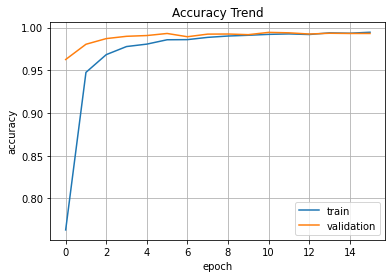

In [21]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

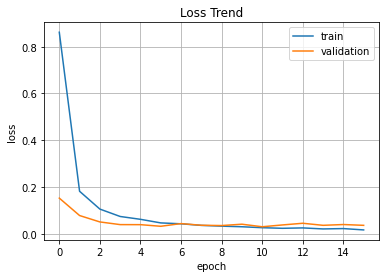

In [22]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()